In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Concatenate, DepthwiseConv2D, Multiply,
    Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Add, Reshape, AveragePooling2D
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
# Any additional code or custom layers you have can be added here.


In [19]:
input_shape = (224, 224, 3)

test_dir = '/root/BreastCancer/BCResize/40X/test'
train_dir = '/root/BreastCancer/BCResize/40X/train'


batch_size = 32
num_classes = 2
# filter_factor = 8

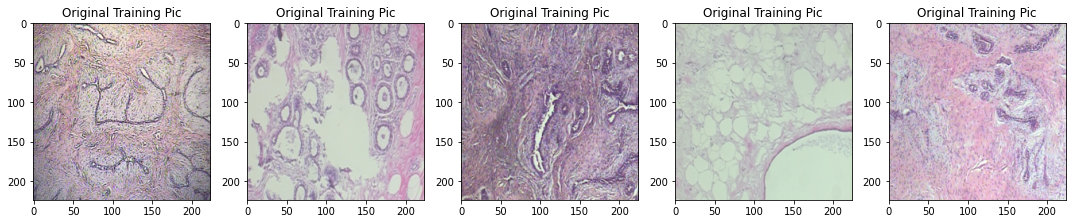

In [3]:
train_diabetic = '/root/BreastCancer/BCResize/40X/test/benign'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2262 images belonging to 2 classes.
Found 338 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


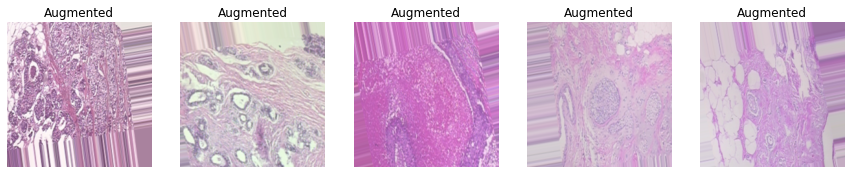

In [5]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# import scipy

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [6]:
# we reduce # filters by factor of 8 compared to original inception-v4
nb_filters_reduction_factor = 8

def inception_resnet_v2_stem(x):
    # Updated to use Conv2D and correct parameters
    x = Conv2D(32 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    x = Conv2D(32 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    x = Conv2D(64 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)

    a = MaxPooling2D((3, 3), strides=(1, 1), padding='valid')(x)
    b = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    x = Concatenate(axis=-1)([a, b])

    a = Conv2D(64 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    a = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(a)
    b = Conv2D(64 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    b = Conv2D(64 // nb_filters_reduction_factor, (7, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    b = Conv2D(64 // nb_filters_reduction_factor, (1, 7), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    b = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(b)
    x = Concatenate(axis=-1)([a, b])

    a = Conv2D(192 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    b = MaxPooling2D((3, 3), strides=(1, 1), padding='valid')(x)
    x = Concatenate(axis=-1)([a, b])

    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_A(x):
    shortcut = x
    
    a = Conv2D(32 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    b = Conv2D(32 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    b = Conv2D(32 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    
    c = Conv2D(32 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    c = Conv2D(48 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(c)
    c = Conv2D(64 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(c)
    
    x = Concatenate(axis=-1)([a, b, c])
    x = Conv2D(384 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='linear',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

def inception_resnet_v2_reduction_A(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(384 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    c = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    c = Conv2D(256 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(c)
    c = Conv2D(384 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(c)
    
    x = Concatenate(axis=-1)([a, b, c])
    
    return x
    

def inception_resnet_v2_B(x):
    shortcut = x
    
    a = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    b = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    b = Conv2D(160 // nb_filters_reduction_factor, (1, 7), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    b = Conv2D(192 // nb_filters_reduction_factor, (7, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    
    x = Concatenate(axis=-1)([a, b])
    x = Conv2D(1154 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='linear',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_B(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    b = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(b)
    c = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    c = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(c)
    d = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    d = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(d)
    d = Conv2D(320 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(d)
    
    x = Concatenate(axis=-1)([a, b, c, d])
    
    return x


def inception_resnet_v2_C(x):
    shortcut = x
    
    a = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    b = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    b = Conv2D(224 // nb_filters_reduction_factor, (1, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    b = Conv2D(256 // nb_filters_reduction_factor, (3, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    
    x = Concatenate(axis=-1)([a, b])
    x = Conv2D(2048 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='linear',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

In [7]:

# img_rows, img_cols = 32, 32
# img_channels = 3

# in original inception-resnet-v2, these are 5, 10, 5, respectively
num_A_blocks = 5
num_B_blocks = 10
num_C_blocks = 5

inputs = Input(shape=input_shape)

x = inception_resnet_v2_stem(inputs)
for i in range(num_A_blocks):
    x = inception_resnet_v2_A(x)
x = inception_resnet_v2_reduction_A(x)
for i in range(num_B_blocks):
    x = inception_resnet_v2_B(x)
x = inception_resnet_v2_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_resnet_v2_C(x)

x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

2023-12-25 11:57:40.544129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-25 11:57:41.084709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 4)  112         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 220, 220, 4)  148         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 220, 220, 8)  296         ['conv2d_1[0][0]']           

In [8]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K


model.compile(
    optimizer='adam',
    loss = "categorical_crossentropy",
    metrics=[
        "accuracy", 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=2, average = 'micro')
    ]
)

MODEL_NAME = "IRV2_40XResized"  # 用您的模型名替换
# 训练合并后的模型
csv_logger = tf.keras.callbacks.CSVLogger(
    fr"/root/BreastCancer/CSVHistory/3. InceptionResNet/{MODEL_NAME}.csv", 
    separator=",", 
    append=False)

lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)





In [9]:
history = model.fit(
    train_generator,
    epochs=100,  # 根据需要调整epochs数
    validation_data=validation_generator,
    callbacks=[csv_logger, lr_reduction]  # 添加 ModelCheckpoint 到回调列表
)

Epoch 1/100


2023-12-25 11:57:50.455567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-25 11:57:52.502736: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


71/71 [==============================] - 42s 445ms/step - loss: 11.5318 - accuracy: 0.5318 - precision: 0.5318 - recall: 0.5318 - auc: 0.5366 - f1_score: 0.5318 - val_loss: 0.7976 - val_accuracy: 0.5237 - val_precision: 0.5237 - val_recall: 0.5237 - val_auc: 0.6337 - val_f1_score: 0.5237 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 29s 403ms/step - loss: 0.5835 - accuracy: 0.7065 - precision: 0.7065 - recall: 0.7065 - auc: 0.7636 - f1_score: 0.7065 - val_loss: 0.5281 - val_accuracy: 0.7101 - val_precision: 0.7101 - val_recall: 0.7101 - val_auc: 0.8263 - val_f1_score: 0.7101 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 29s 402ms/step - loss: 0.5489 - accuracy: 0.7330 - precision: 0.7330 - recall: 0.7330 - auc: 0.7966 - f1_score: 0.7330 - val_loss: 0.5013 - val_accuracy: 0.7367 - val_precision: 0.7367 - val_recall: 0.7367 - val_auc: 0.8413 - val_f1_score: 0.7367 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - 29s 403ms/step - lo

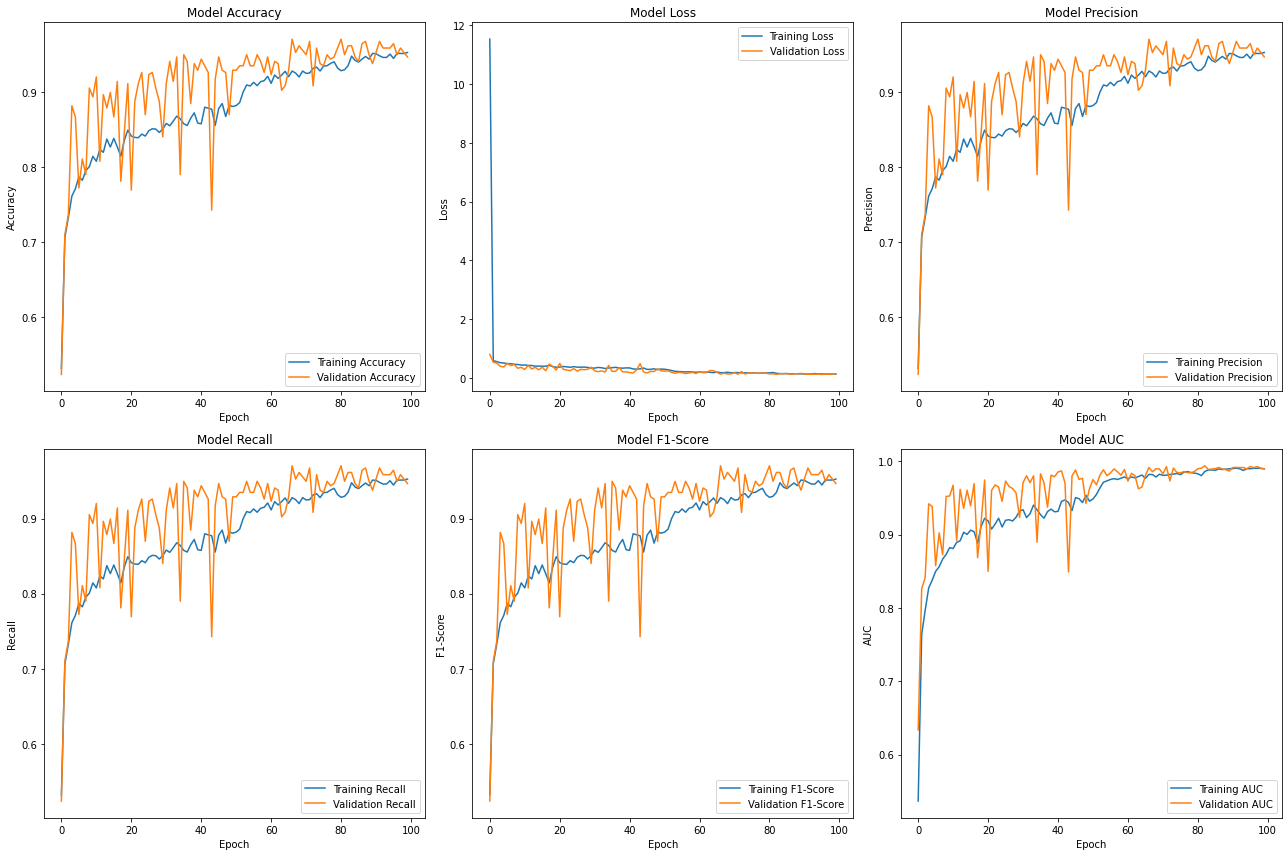

In [10]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

2023-12-25 12:46:07.641013: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1560674304 exceeds 10% of free system memory.
2023-12-25 12:46:08.468621: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1560674304 exceeds 10% of free system memory.


81/81 [==============================] - 10s 111ms/step


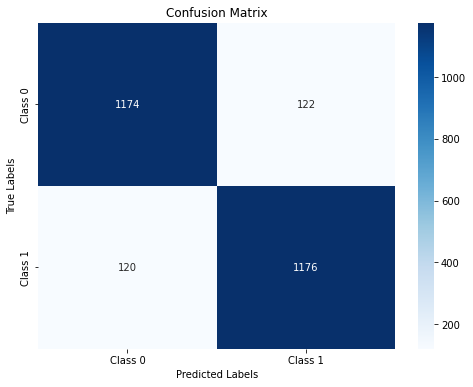

In [11]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# 进行预测并获取预测标签
predictions = model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [12]:
from sklearn.metrics import f1_score


# 计算F1-Score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(all_true_labels, predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


F1-Score: 0.9066357468824702
F1-Score for each class: [0.90656371 0.90670779]


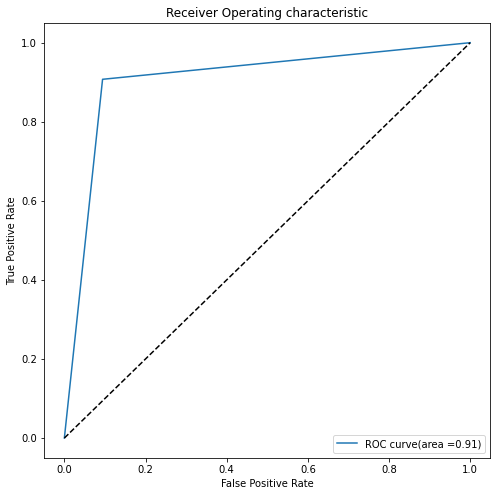

In [13]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(all_true_labels, predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [14]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.9074074074074074
specificity: 0.9058641975308642


2023-12-25 12:46:19.376806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1560674304 exceeds 10% of free system memory.
2023-12-25 12:46:20.320538: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1560674304 exceeds 10% of free system memory.


81/81 [==============================] - 9s 111ms/step


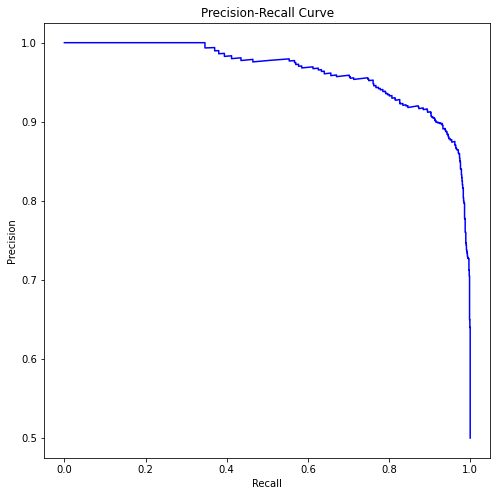

In [15]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs =  model.predict(all_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [16]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

82/82 [==============================] - 10s 118ms/step - loss: 0.2445 - accuracy: 0.9065 - precision: 0.9065 - recall: 0.9065 - auc: 0.9671 - f1_score: 0.9065
Test loss: 0.24449138343334198
Test accuracy: 0.9065384864807129
Test precision: 0.9065384864807129
Test recall: 0.9065384864807129
Test AUC: 0.9670889973640442
Test F1 Score: 0.9065384864807129


In [17]:
from sklearn.metrics import classification_report

# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = model.predict(all_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(all_true_labels, y_pred_labels)
print(report)


2023-12-25 12:46:40.236474: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1560674304 exceeds 10% of free system memory.


81/81 [==============================] - 9s 111ms/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1296
           1       0.91      0.91      0.91      1296

    accuracy                           0.91      2592
   macro avg       0.91      0.91      0.91      2592
weighted avg       0.91      0.91      0.91      2592



In [18]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model


from numba import cuda

cuda.select_device(0)
cuda.close()